In [1]:
import numpy as np
import torch
import torch.nn as nn

from nets import GraphNN_KNN_v1, EdgeClassifier_v1
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, average_precision_score
from torch_geometric.data import DataLoader
from preprocessing import preprocess_dataset
from tqdm import tqdm

def predict_one_shower(shower, graph_embedder, edge_classifier):
    # TODO: batch training
    embeddings = graph_embedder(shower)
    edge_labels_true = ((shower.y[shower.edge_index[0]] == shower.y[shower.edge_index[1]])).view(-1)
    edge_labels_predicted = edge_classifier(shower=shower, embeddings=embeddings, edge_index=shower.edge_index).view(-1)
    return edge_labels_true, torch.clamp(edge_labels_predicted, 1e-6, 1 - 1e-6)

In [2]:
import hdbscan
from hdbscan import plots as hdbscan_plot
import networkx as nx
from clustering import preprocess_torch_shower_to_nx
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context='paper', style="whitegrid", font_scale=2)


min_cl = 40
cl_size = min_cl

In [3]:
datafile='../data/train_200_preprocessed__.pt'; epochs=1000; learning_rate=1e-3; dim_out=144; device='cpu';
device = torch.device("cpu")
showers = torch.load(datafile)

In [4]:
output_dim=32
hidden_dim=32
input_dim = showers[0].x.shape[1]
edge_dim = showers[0].edge_features.shape[1]
num_layers_emulsion = 3
num_layers_edge_conv = 5
showers = DataLoader(showers, batch_size=1, shuffle=False)

In [5]:
key = "579d9fc429274d72a9be79c244eed210"
graph_embedder = GraphNN_KNN_v1(
    output_dim=output_dim,
    hidden_dim=hidden_dim,
    edge_dim=edge_dim,
    num_layers_emulsion=num_layers_emulsion,
    num_layers_edge_conv=num_layers_edge_conv,
    input_dim=input_dim,
).to(device)
edge_classifier = EdgeClassifier_v1(
    input_dim=2 * output_dim + edge_dim,
).to(device)
graph_embedder.load_state_dict(torch.load("../data/graph_embedder_train_200_preprocessed_{}.pt".format(key), map_location=device))
edge_classifier.load_state_dict(torch.load("../data/edge_classifier_train_200_preprocessed_{}.pt".format(key), map_location=device))
graph_embedder.eval()
edge_classifier.eval()

EdgeClassifier_v1(
  (_layers): ModuleList(
    (0): Linear(in_features=71, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [6]:
for shower in showers:
    break

In [7]:
true_labels, weights = predict_one_shower(shower, graph_embedder=graph_embedder, edge_classifier=edge_classifier)
weights = weights.detach().cpu().numpy()
weights =  -np.log((1 - weights) / (weights))
true_labels = true_labels.detach().cpu().numpy()

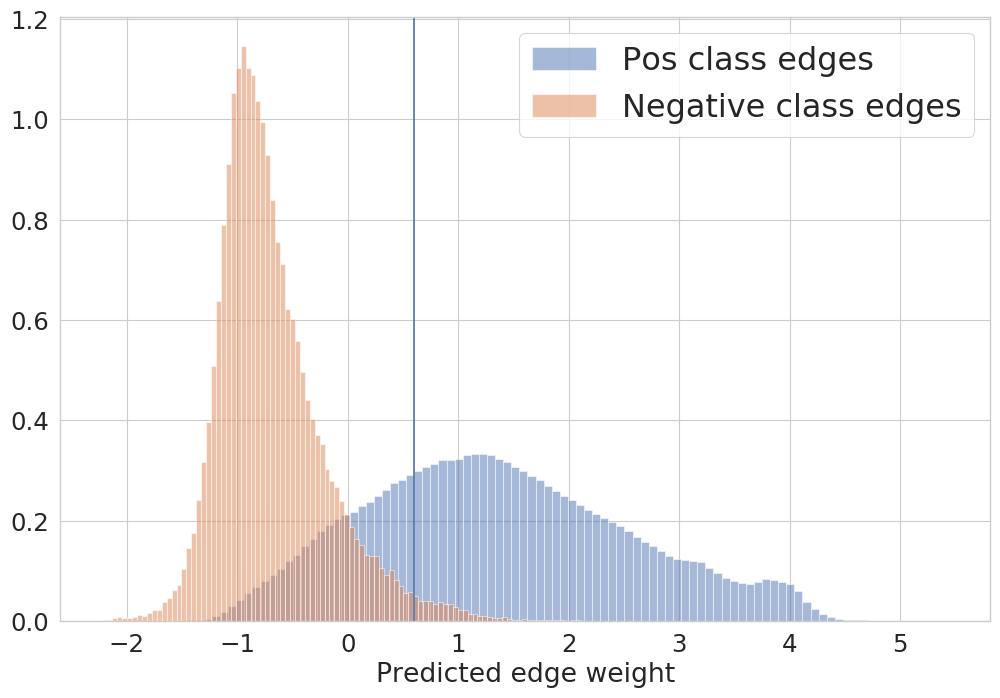

In [8]:
plt.figure(figsize=(12, 8), dpi=100)
plt.title("")
plt.hist(weights[true_labels], bins=100, density=True, alpha=0.5, label="Pos class edges");
plt.hist(weights[~true_labels], bins=100, density=True, alpha=0.5, label="Negative class edges");
plt.axvline(0.6)
plt.xlabel("Predicted edge weight")
# plt.ylim
plt.legend(loc='upper right', fontsize='large')
plt.savefig("hist_predictions.pdf", bbox_inches='tight')
plt.show()

In [9]:
len(weights[true_labels])

3157543

In [10]:
len(weights[~true_labels])

79364